<a href="https://colab.research.google.com/github/top-data/Soil_moisture/blob/main/sm_cosmoz_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and authentication

In [2]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import geemap
from datetime import datetime, timedelta


# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='ee-mhdsaki')

# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Converting image to dataframe

In [3]:
# image to df converter function

def image_to_df(sat_product, bands, gps, dates):
    """
    Inputs: satellite data product, desired bands, gps, date
    Output: pandas dataframe with selected bands and date
    Returns:

    """
    # Define the ImageCollection
    image = ee.ImageCollection(sat_product) \
              .select(bands) \
              .filterDate(dates[0], dates[1])

    # Define a global bounding box geometry
    global_geometry = ee.Geometry.Polygon(
        [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]
    )

    # Define a local bounding box geometry
    local_geometry = ee.Geometry.Rectangle([30, -10, 40, 10])

    # Define a single geometry
    single_geometry = ee.Geometry.Point(gps)

    # Function to extract the date and mean values of bands
    def image_to_dict(image):
        # Get the date of the image
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        # Get the mean soil moisture values over the global geometry
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=single_geometry, # or local_geometry # or global_geometry
            scale=10000,
            maxPixels=1e9
        )
        # Create a dictionary to store the data
        data = {'date': date}
        # Iterate over the bands and add their values to the dictionary
        for band in bands:
            data[band] = stats.get(band)
        return ee.Feature(None, data)

    # Map the function over the ImageCollection
    data_features = image.map(image_to_dict)

    # Convert the ImageCollection to a FeatureCollection, then to a list of dictionaries
    features_dicts = data_features.getInfo()['features']

    # Convert to pandas DataFrame
    data_dict = [{'date': f['properties']['date'],
                  **{band: f['properties'][band] for band in bands}} for f in features_dicts]

    df = pd.DataFrame(data_dict)

    return df




# Loading data

## Loading satellite data



## List of sites for in-situ soil moisture

In [57]:
stations = {
    'site_no': ['station6', 'station7', 'station8', 'station10', 'station11', 'station15', 'station18', 'station19', 'station21', 'station23', 'station25', 'station26', 'station27', 'station29', 'station32'],
    'site_name': ['RobsonCk', 'Temora', 'Tullochgorum', 'WeanyCk', 'Yanco', 'Hamilton', 'Bishes', 'Bennets', 'Bullawarrie', 'BCS_Conservatively', 'BCS_Brigalow', 'BCS_Heavily', 'Boorowa', 'Credo', 'OakValley'],
    'lat':[-17.116, -34.405, -41.669, -19.882, -35.005, -37.828, -35.769, -35.826, -28.809, -24.812, -24.815, -24.811, -34.471, -30.191, -19.439],
    'lon': [145.630, 147.533, 147.912, 146.536, 146.299, 142.089, 142.973, 143.004, 148.765, 149.801, 149.794, 149.790, 148.697, 120.654, 146.827]
    }

stations_df = pd.DataFrame(stations)
stations_df


,site_no,site_name,lat,lon
0,station6,RobsonCk,-17.116,145.630
1,station7,Temora,-34.405,147.533
2,station8,Tullochgorum,-41.669,147.912
3,station10,WeanyCk,-19.882,146.536
4,station11,Yanco,-35.005,146.299
5,station15,Hamilton,-37.828,142.089
6,station18,Bishes,-35.769,142.973
7,station19,Bennets,-35.826,143.004
8,station21,Bullawarrie,-28.809,148.765
9,station23,BCS_Conservatively,-24.812,149.801


In [61]:
stations_df.iloc[1]['site_no']

'station7'

In [65]:
def build_smap_cosmoz(station_data):
  # Function to download data for a specific period
  def download_smap_data(start_date, end_date, sat_product, bands, gps):
      dates = [start_date, end_date]
      return image_to_df(sat_product, bands, gps, dates)

  # Parameters
  sat_product = 'NASA/SMAP/SPL4SMGP/007'
  bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
          'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']
  gps = [station_data['lon'], station_data['lat']] # station7 (site: Temora)
  start_date = datetime(2020, 8, 15)
  end_date = datetime(2024, 8, 15)

  # Empty list to store DataFrames
  dfs = []

  # Loop through the date range in 3-month intervals
  current_start = start_date
  while current_start < end_date:
      current_end = min(current_start + timedelta(days=90), end_date)
      df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
      dfs.append(df)
      current_start = current_end

  # Combine all DataFrames into one
  smap_df = pd.concat(dfs)

  # Process the combined DataFrame
  smap_df['date'] = pd.to_datetime(smap_df['date'])  # Convert 'date' to datetime
  smap_df.set_index('date', inplace=True)  # Set 'date' as index
  smap_df.dropna(inplace=True)
  smap_df.to_csv(f"/content/drive/MyDrive/SoilMoisture/cosmoz/smap_{station_data['site_no']}.csv")

  # loading in-situ data (cosmoz stations)
  cosmoz_data = pd.read_csv(f"/content/drive/MyDrive/SoilMoisture/cosmoz/{station_data['site_no']}_level4.csv")
  cosmoz_data = cosmoz_data.rename(columns={'UTC_TIMESTAMP': 'date'})
  cosmoz_data['date'] = pd.to_datetime(cosmoz_data['date'])
  cosmoz_data.set_index('date', inplace=True)

  # Resample smap_df to daily and average values
  smap_df_daily = smap_df.resample('D').mean()

  # Resample cosmoz data to daily and average values
  cosmoz_data_daily = cosmoz_data.resample('D').mean()/100

  # Merge the two dataframes on 'date'
  merged_df = pd.merge(smap_df_daily, cosmoz_data_daily, on='date', how='inner')

  merged_df.dropna(subset=['SOIL_MOISTURE_percent'], inplace=True)

  return merged_df


In [66]:
all_smap_stations = []
for index, row in stations_df.iterrows():
  merged_df = build_smap_cosmoz(row)
  all_smap_stations.append(merged_df)

In [67]:
merged_df_all = pd.concat(all_smap_stations)
merged_df_all.to_csv('/content/drive/MyDrive/SoilMoisture/cosmoz/merged_df_all.csv')

In [69]:
merged_df_all.corr()['SOIL_MOISTURE_percent'].sort_values(ascending=False)

,SOIL_MOISTURE_percent
SOIL_MOISTURE_percent,1.000000
7H_SOIL_MOISTURE_percent,0.999810
sm_surface_wetness,0.685789
sm_surface,0.653562
sm_rootzone_wetness,0.580082
sm_profile_wetness,0.579875
sm_rootzone,0.509688
sm_profile,0.509041
RAIN_mm,0.023507
soil_temp_layer6,-0.224593


## Plot (satellite and in-situ)

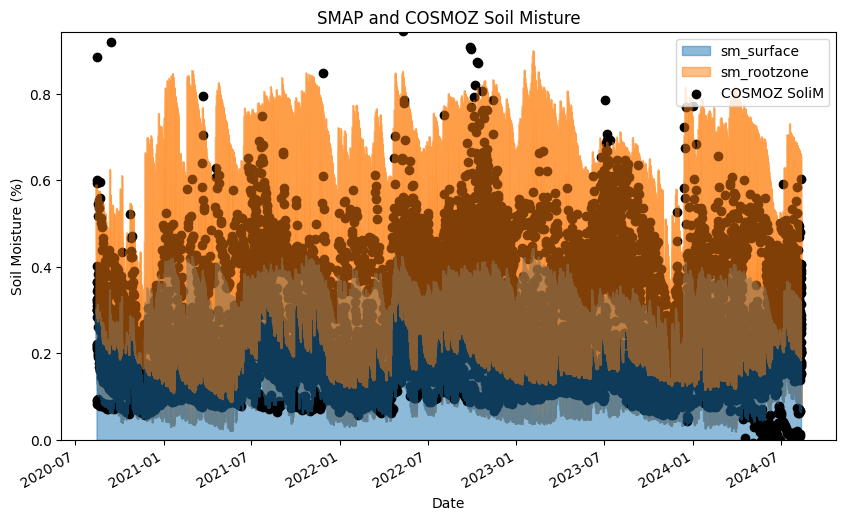

In [73]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot stacked area chart for col1 and col2
merged_df_all[['sm_surface', 'sm_rootzone']].plot(kind='area', stacked=True, ax=ax1, alpha=0.5)

# Plot line plot for col3
ax1.scatter(merged_df_all.index, merged_df_all['SOIL_MOISTURE_percent'], color='black', label='COSMOZ SoliM')


# Add labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Soil Moisture (%)')

# Add legends
ax1.legend(loc='upper right')

# Show plot
plt.title('SMAP and COSMOZ Soil Misture')
plt.show()


# Modelling

## Data Preparation

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Input, Dropout, Flatten
from xgboost import XGBRegressor

bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
          'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

# Prepare features and target
X = merged_df_all[bands].values
y = merged_df_all['SOIL_MOISTURE_percent'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Transformer Model with MultiHeadAttention

In [76]:
import tensorflow as tf

# Define Transformer model
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for transformer model
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

transformer_model = build_transformer_model((1, X_train_scaled.shape[1]))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
transformer_model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[callback])


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


356/356 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0106 - val_loss: 0.0045
Epoch 2/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 3/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 4/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 7/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 8/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 10/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 11/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 12/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13m

## LSTM Model

In [77]:
# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for LSTM model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = build_lstm_model((1, X_train_scaled.shape[1]))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[callback])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0192 - val_loss: 0.0049
Epoch 2/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 3/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 5/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 6/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 7/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 10/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 11/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 12/200
356/356 ━━━━━━━━━━━━━━━━━━━━

## XGBoost Model

In [78]:
# Define and train XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluation

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate the model

def evaluate_model(model, X_test, y_test, model_type='keras'):
    if model_type == 'keras':
        y_pred = model.predict(X_test).flatten()
    elif model_type == 'xgboost':
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2
# Evaluate Transformer model
transformer_mse, transformer_rmse, transformer_r2 = evaluate_model(transformer_model, X_test_reshaped, y_test, model_type='keras')

# Evaluate LSTM model
lstm_mse, lstm_rmse, lstm_r2 = evaluate_model(lstm_model, X_test_lstm, y_test, model_type='keras')

# Evaluate XGBoost model
xgb_mse, xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test_scaled, y_test, model_type='xgboost')

# Create a DataFrame to show the results
results_df = pd.DataFrame({
    'Model': ['Transformer', 'LSTM', 'XGBoost'],
    'MSE': [transformer_mse, lstm_mse, xgb_mse],
    'RMSE': [transformer_rmse, lstm_rmse, xgb_rmse],
    'R-Squared': [transformer_r2, lstm_r2, xgb_r2]
})

results_df


 56/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Model,MSE,RMSE,R-Squared
0,Transformer,0.002693,0.051897,0.823312
1,LSTM,0.002513,0.050126,0.835165
2,XGBoost,0.001393,0.037323,0.908616


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


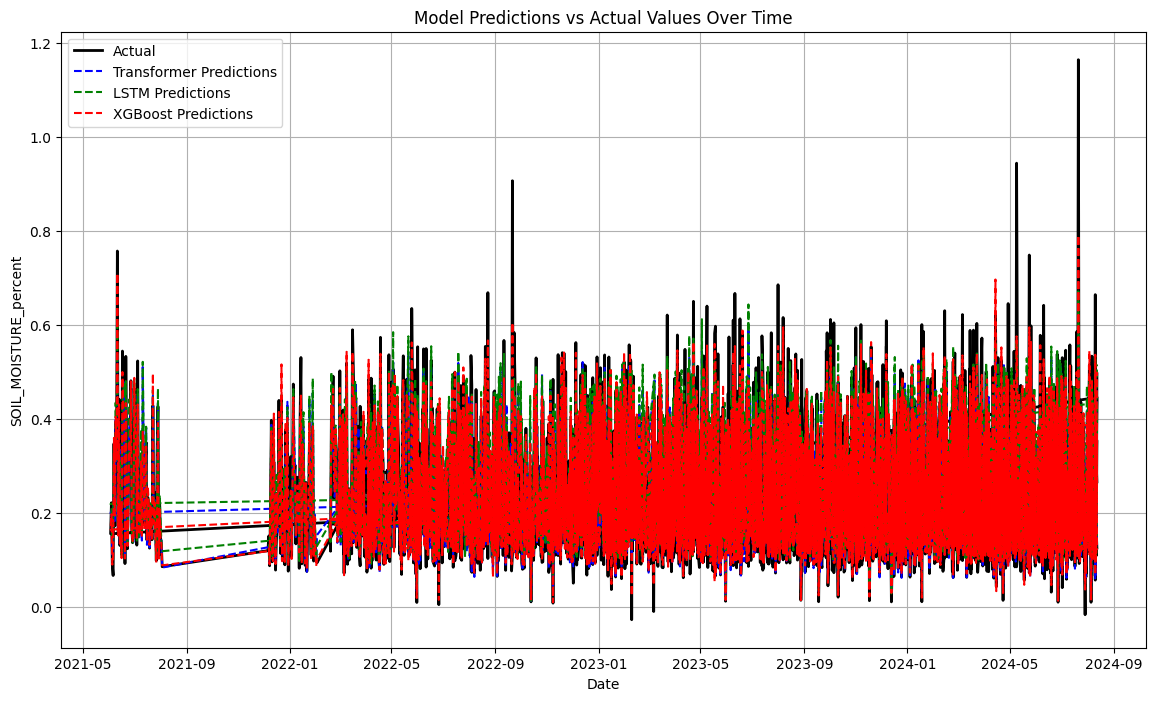

In [81]:
import matplotlib.pyplot as plt

# Get corresponding dates for y_test
test_dates = merged_df_all.index[-len(y_test):]

# Generate predictions
transformer_predictions = transformer_model.predict(X_test_reshaped).flatten()
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
xgb_predictions = xgb_model.predict(X_test_scaled)

# Plot the actual values and predictions vs date
plt.figure(figsize=(14, 8))

plt.plot(test_dates, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, transformer_predictions, label='Transformer Predictions', color='blue', linestyle='--')
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions', color='green', linestyle='--')
plt.plot(test_dates, xgb_predictions, label='XGBoost Predictions', color='red', linestyle='--')

plt.title('Model Predictions vs Actual Values Over Time')
plt.xlabel('Date')
plt.ylabel('SOIL_MOISTURE_percent')
plt.legend()
plt.grid(True)
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


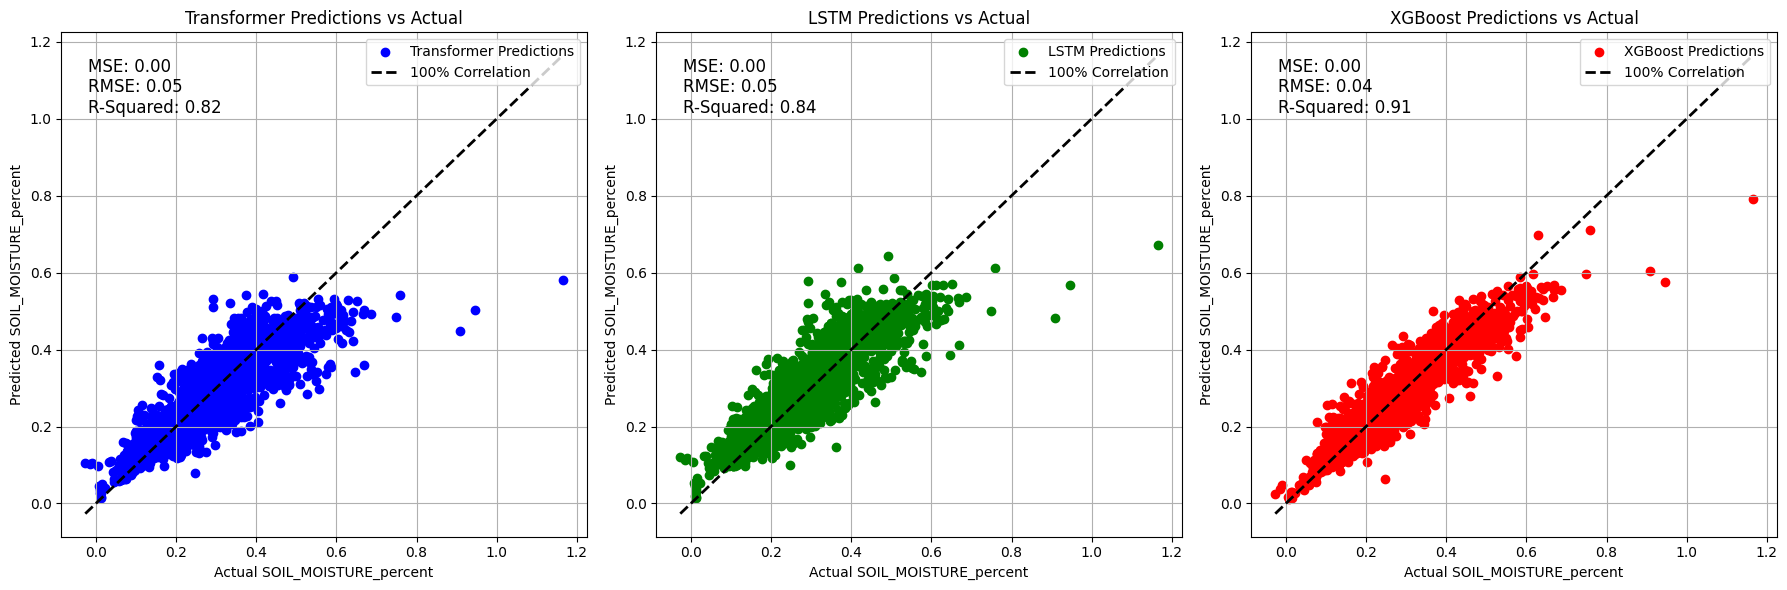

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Generate predictions
transformer_predictions = transformer_model.predict(X_test_reshaped).flatten()
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)

lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_predictions)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 3, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# LSTM model
plt.subplot(1, 3, 2)
plt.scatter(y_test, lstm_predictions, color='green', label='LSTM Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {lstm_mse:.2f}\nRMSE: {lstm_rmse:.2f}\nR-Squared: {lstm_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# XGBoost model
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# Saving the pipeline

## Create the pipline class

In [83]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model

class SoilMoisturePredictor:
    def __init__(self, scaler, model):
        self.scaler = scaler
        self.model = model

    def preprocess(self, X):
        # Scale the input features
        X_scaled = self.scaler.transform(X)
        # Reshape for Transformer model
        X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        return X_reshaped

    def predict(self, X):
        # Preprocess the input
        X_preprocessed = self.preprocess(X)
        # Make predictions using the model
        predictions = self.model.predict(X_preprocessed)
        return predictions

    def save(self, filepath):
        # Save the scaler and model
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        # save_model(self.model, f'{filepath}_model.h5')
        self.model.save(f'{filepath}_model.keras')

    @classmethod
    def load(cls, filepath):
        # Load the scaler and model
        scaler = joblib.load(f'{filepath}_scaler.pkl')
        # model = load_model(f'{filepath}_model.h5')
        model = load_model(f'{filepath}_model.keras')
        return cls(scaler, model)


## Save the pipline

In [84]:
# Create an instance of SoilMoisturePredictor
predictor = SoilMoisturePredictor(scaler=scaler, model=transformer_model)

# Save the predictor instance
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'
predictor.save(model_path)



## Save the xgb pipeline

In [85]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Example Preprocessing and Model Pipeline
xgb_pipeline = Pipeline([
    ('scaler', scaler),  # Add other preprocessing steps if necessary
    ('xgb_model', xgb_model)  # Replace with the trained XGBoost model
])

model_path = '/content/drive/MyDrive/SoilMoisture/'

# Save the pipeline
joblib.dump(xgb_pipeline, f'{model_path}xgb_pipeline.pkl')


['/content/drive/MyDrive/SoilMoisture/xgb_pipeline.pkl']

# Load and Use the Encapsulated Model

### Load new satellite data for a different location (site)

In [86]:
# Parameters
sat_product = 'NASA/SMAP/SPL4SMGP/007'

bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
         'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

gps = [146.299, -35.005] # station11 (site: Yanco)
start_date = datetime(2023, 8, 15)
end_date = datetime(2024, 8, 15)

# Empty list to store DataFrames
dfs = []

# Loop through the date range in 3-month intervals
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=90), end_date)
    df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
    dfs.append(df)
    current_start = current_end

# Combine all DataFrames into one
smap_df_new = pd.concat(dfs)

# Process the combined DataFrame
smap_df_new['date'] = pd.to_datetime(smap_df_new['date'])  # Convert 'date' to datetime
smap_df_new.set_index('date', inplace=True)  # Set 'date' as index


## Load the transformer model and predict new data

In [87]:
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'

# Load the predictor instance
model_transformer = SoilMoisturePredictor.load(model_path)

# Resample smap_df to daily and average values
smap_df_daily_new = smap_df_new.resample('D').mean()


# Prepare input for prediction
X_new = smap_df_daily_new[bands].values

# Make predictions using the loaded predictor
transformer_predictions_new = model_transformer.predict(X_new)



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## Load the xgb model and predict new data

In [88]:
model_path = '/content/drive/MyDrive/SoilMoisture/'

# Load the pipeline
xgb_pipeline = joblib.load(f'{model_path}xgb_pipeline.pkl')

# Use the pipeline to predict on new data
xgb_predictions_new = xgb_pipeline.predict(X_new)  # new_data will be automatically scaled using the fitted scaler


### Loading in-situ for new data

In [94]:
staion11_soilM = pd.read_csv('/content/drive/MyDrive/SoilMoisture/station11_level4_1y.csv')
staion11_soilM = staion11_soilM.rename(columns={'UTC_TIMESTAMP': 'date'})
staion11_soilM['date'] = pd.to_datetime(staion11_soilM['date'])
staion11_soilM.set_index('date', inplace=True)
staion11_soilM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8778 entries, 2023-08-15 15:24:08 to 2024-08-15 13:13:40
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SOIL_MOISTURE_percent     8778 non-null   float64
 1   EFFECTIVE_DEPTH_cm        8778 non-null   float64
 2   RAIN_mm                   8778 non-null   float64
 3   7H_SOIL_MOISTURE_percent  8778 non-null   float64
 4   7H_DEPTH_cm               8778 non-null   float64
dtypes: float64(5)
memory usage: 411.5 KB


### Resampling and merging new data

In [95]:

# Resample staion7_soilM to daily and average values
staion11_soilM_daily = staion11_soilM.resample('D').mean()/100

# Merge the two dataframes on 'date'
merged_df_new = pd.merge(smap_df_daily_new, staion11_soilM_daily, on='date', how='inner')


# Display the merged dataframe
merged_df_new.tail()

,sm_surface,sm_rootzone,sm_profile,sm_surface_wetness,sm_rootzone_wetness,sm_profile_wetness,surface_temp,soil_temp_layer1,soil_temp_layer2,soil_temp_layer3,soil_temp_layer4,soil_temp_layer5,soil_temp_layer6,SOIL_MOISTURE_percent,EFFECTIVE_DEPTH_cm,RAIN_mm,7H_SOIL_MOISTURE_percent,7H_DEPTH_cm
date,,,,,,,,,,,,,,,,,,
2024-08-08,0.162131,0.219471,0.229325,0.359652,0.486848,0.508706,284.248528,283.553940,283.090546,283.584347,285.312046,288.281891,290.508102,0.324797,0.122840,0.0,0.320856,0.123907
2024-08-09,0.161836,0.218925,0.228761,0.358998,0.485636,0.507456,285.265198,284.808247,284.039551,283.789055,285.302616,288.240368,290.506126,0.298267,0.129833,0.0,0.300639,0.129160
2024-08-10,0.156489,0.218055,0.228005,0.347135,0.483707,0.505779,285.239094,285.002403,284.537746,284.092106,285.311031,288.199818,290.504059,0.292472,0.134148,0.0,0.292606,0.133719
2024-08-11,0.146575,0.216936,0.227092,0.325144,0.481225,0.503754,285.794712,285.363602,284.795849,284.365692,285.337177,288.160587,290.501999,0.356514,0.115435,0.0,0.352479,0.117051
2024-08-12,0.142382,0.216215,0.226396,0.315842,0.479625,0.502208,287.065781,286.340179,285.322422,284.635422,285.377296,288.122910,290.499847,0.339771,0.119123,0.0,0.339940,0.119096


### Plot the predictions for new data vs in-situ

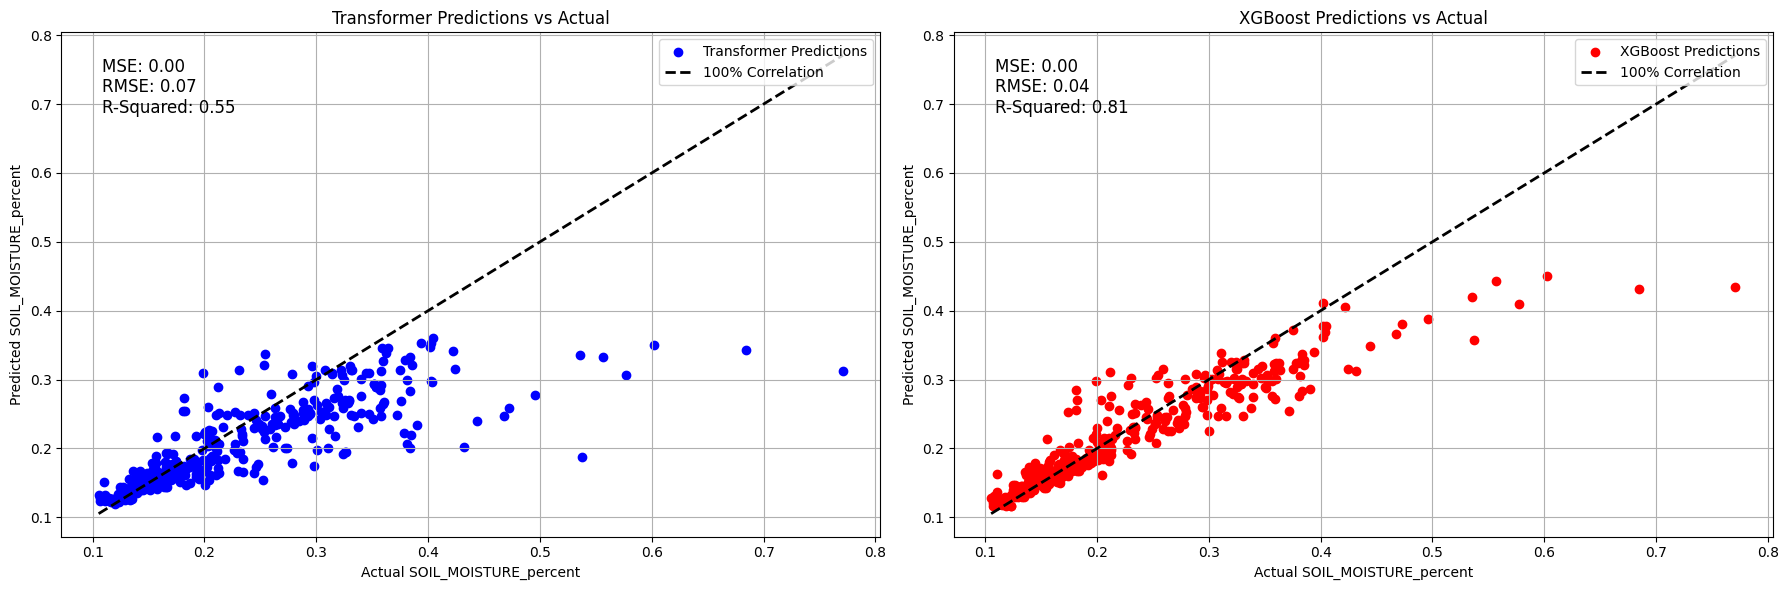

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_test = merged_df_new['SOIL_MOISTURE_percent']

# Generate predictions
transformer_predictions = transformer_predictions_new.flatten()
xgb_predictions = xgb_predictions_new

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)


xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 2, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)


# XGBoost model
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:


# # Plot the actual values and predictions vs date
# plt.figure(figsize=(14, 8))

# plt.plot(merged_df.index, merged_df['SOIL_MOISTURE_percent'], label='SoilM (in-situ)', color='black', linewidth=2)
# plt.plot(merged_df.index, transformer_predictions, label='SoilM (predicted)', color='blue', linestyle='--')
# plt.plot(merged_df.index, merged_df['sm_surface'], label='sm_surface', linewidth=2)
# plt.plot(merged_df.index, merged_df['sm_rootzone'], label='sm_rootzone', linewidth=2)



# plt.title('Model Predictions vs Actual Values Over Time')
# plt.xlabel('Date')
# plt.ylabel('Soil Moisture (%)')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import seaborn as sns

# df = merged_df.copy()
# df['predicted_soilM'] = fresh_predictions
# df['surface_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_surface']
# df['root_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_rootzone']
# df['pred_actual'] = df['SOIL_MOISTURE_percent'] - df['predicted_soilM']

# # Plotting the box plots
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df[['pred_actual', 'surface_actual', 'root_actual']])
# plt.title('Box Plots of Soil Moisture Differences')
# # plt.xlabel('Soil elements')
# plt.ylabel('Error Distribution')
# plt.show()